In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
# Load JSON file (structured as list of records)
df = pd.read_json('iot_data_BAW_PAL.json')

# Preview the first few rows
print(df.head())


              record_id   distance  food_weight  humidity  temperature  \
0  -OOsCpplASX7pPnHuoM3  100.32750       318.87        81         29.1   
1  -OOsCr86ynUgXR5Kohh0  100.39610       321.07        81         29.1   
2  -OOsCsRDSl0tZjDaDZdS  100.75625       321.07        81         29.1   
3  -OOsCtjIJ6OO5DluFwZ6  100.79055       321.01        81         29.1   
4  -OOsCv1z2GgzjbXKQg2I  100.80770       321.78        81         29.1   

                  timestamp  
0 2025-04-27 22:36:56+00:00  
1 2025-04-27 22:37:01+00:00  
2 2025-04-27 22:37:06+00:00  
3 2025-04-27 22:37:12+00:00  
4 2025-04-27 22:37:17+00:00  


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values("timestamp").reset_index(drop=True)

In [4]:
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['day'] = df['timestamp'].dt.day
df['time_index'] = df['hour'] + df['minute'] / 60 # fractional hour

In [5]:
features_temp = ['hour', 'minute', 'day']
target_temp = 'temperature'
target_hum = 'humidity'

X_temp = df[features_temp]
y_temp = df[target_temp]
y_hum = df[target_hum]

In [6]:
last_time = df['timestamp'].iloc[-1]
future_times = [last_time + pd.Timedelta(hours=i+1) for i in range(6)]

future_df = pd.DataFrame({
'timestamp': future_times,
'hour': [t.hour for t in future_times],
'minute': [t.minute for t in future_times],
'day': [t.day for t in future_times]
})

In [7]:
temp_model = RandomForestRegressor(n_estimators=100, random_state=0)
temp_model.fit(X_temp, y_temp)

RandomForestRegressor(random_state=0)

In [8]:
hum_model = RandomForestRegressor(n_estimators=100, random_state=0)
hum_model.fit(X_temp, y_hum)

RandomForestRegressor(random_state=0)

In [9]:
X_future = future_df[['hour', 'minute', 'day']]
future_df['predicted_temp'] = temp_model.predict(X_future)
future_df['predicted_hum'] = hum_model.predict(X_future)

print("🔮 Predicted Temperature and Humidity for Next 6 Hours:")
print(future_df[['timestamp', 'predicted_temp', 'predicted_hum']])

🔮 Predicted Temperature and Humidity for Next 6 Hours:
                  timestamp  predicted_temp  predicted_hum
0 2025-05-02 11:16:42+00:00       28.553916      81.271418
1 2025-05-02 12:16:42+00:00       29.300000      81.271418
2 2025-05-02 13:16:42+00:00       29.436561      81.271418
3 2025-05-02 14:16:42+00:00       29.600000      84.099319
4 2025-05-02 15:16:42+00:00       30.300000      75.000000
5 2025-05-02 16:16:42+00:00       30.000000      75.086476


In [11]:
features_weight = ['temperature', 'humidity', 'hour']
df_input = df.copy()
df_input = df_input.rename(columns={'temperature': 'temp', 'humidity': 'hum'})
X_weight = df_input[['temp', 'hum', 'hour']]
y_weight = df_input['food_weight']

In [12]:
weight_model = RandomForestRegressor(n_estimators=100, random_state=42)
weight_model.fit(X_weight, y_weight)

RandomForestRegressor(random_state=42)

In [13]:
future_df['hour'] = future_df['timestamp'].dt.hour
X_future_weight = future_df[['predicted_temp', 'predicted_hum', 'hour']]
X_future_weight.columns = ['temp', 'hum', 'hour']

future_df['predicted_water_weight'] = weight_model.predict(X_future_weight)

print("\n🚰 Predicted Water Weight for Next 6 Hours:")
print(future_df[['timestamp', 'predicted_water_weight']])


🚰 Predicted Water Weight for Next 6 Hours:
                  timestamp  predicted_water_weight
0 2025-05-02 11:16:42+00:00              193.501633
1 2025-05-02 12:16:42+00:00               37.353676
2 2025-05-02 13:16:42+00:00               34.066878
3 2025-05-02 14:16:42+00:00              319.545148
4 2025-05-02 15:16:42+00:00              295.762437
5 2025-05-02 16:16:42+00:00              315.207656


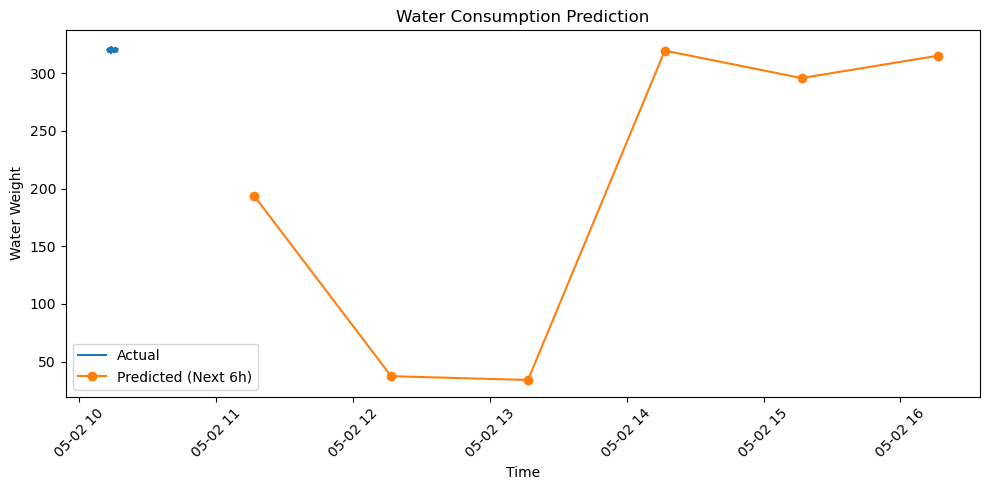

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'].tail(48), df['food_weight'].tail(48), label="Actual")
plt.plot(future_df['timestamp'], future_df['predicted_water_weight'], label="Predicted (Next 6h)", marker='o')
plt.xlabel("Time")
plt.ylabel("Water Weight")
plt.title("Water Consumption Prediction")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

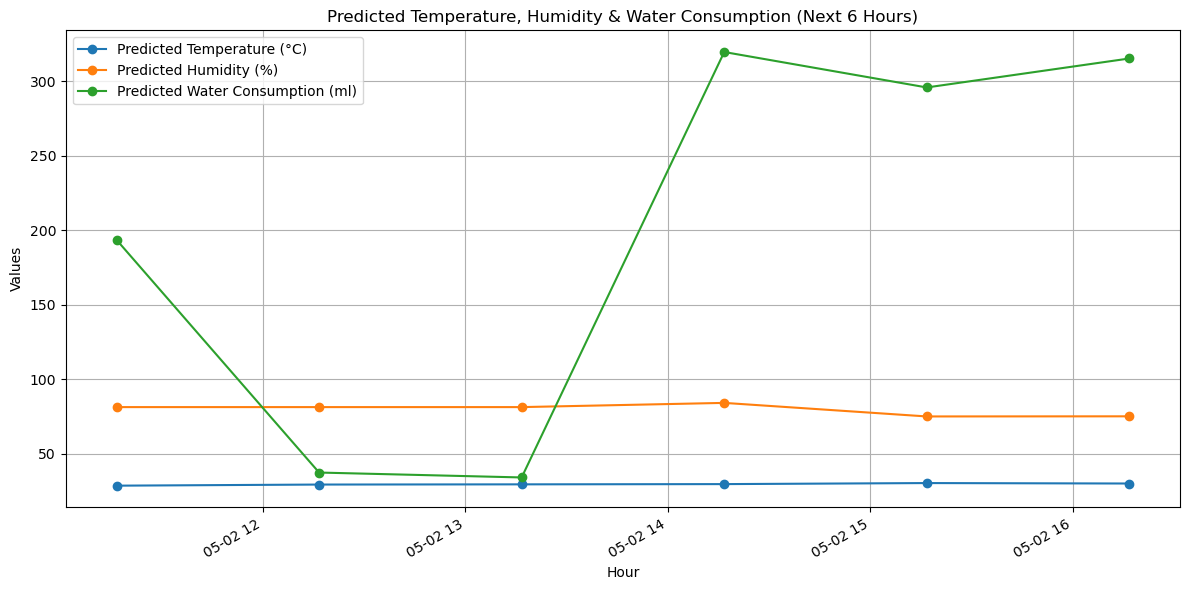

In [20]:
x = future_df['timestamp']

plt.figure(figsize=(12, 6))

plt.plot(x, future_df['predicted_temp'], label="Predicted Temperature (°C)", marker='o')
plt.plot(x, future_df['predicted_hum'], label="Predicted Humidity (%)", marker='o')
plt.plot(x, future_df['predicted_water_weight'], label="Predicted Water Consumption (ml)", marker='o')

plt.title("Predicted Temperature, Humidity & Water Consumption (Next 6 Hours)")
plt.xlabel("Hour")
plt.ylabel("Values")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
df.tail(20)

,record_id,distance,food_weight,humidity,temperature,timestamp,hour,minute,day,time_index
67961,-OPEIxSQrZpOnxSGVowW,108.516481,319.14,81,29.0,2025-05-02 10:14:56+00:00,10,14,2,10.233333
67962,-OPEIynqZKY41dfGR-mA,108.404775,317.99,81,29.0,2025-05-02 10:15:01+00:00,10,15,2,10.250000
67963,-OPEJ-9L2sQY3vp4OFSO,116.820758,320.58,81,29.0,2025-05-02 10:15:07+00:00,10,15,2,10.250000
67964,-OPEJ0W2knFHCnuuD_rO,107.993543,318.97,82,29.0,2025-05-02 10:15:12+00:00,10,15,2,10.250000
67965,-OPEJ1rNspAaiM734oeU,108.287298,321.46,82,29.0,2025-05-02 10:15:18+00:00,10,15,2,10.250000
67966,-OPEJ3CqnB2DXfn5Bsf5,108.490615,321.60,81,29.0,2025-05-02 10:15:23+00:00,10,15,2,10.250000
67967,-OPEJ4vW-9Z20QYuvBCx,108.506567,320.46,81,29.0,2025-05-02 10:15:29+00:00,10,15,2,10.250000
67968,-OPEJ6FvVRuwyINxC8th,107.703103,320.29,81,29.0,2025-05-02 10:15:36+00:00,10,15,2,10.250000
67969,-OPEJ7bMaSPhrWntm0Rp,107.982097,320.62,81,29.0,2025-05-02 10:15:41+00:00,10,15,2,10.250000
67970,-OPEJ8xk-4hwS2gtIhvn,108.174590,319.72,81,29.0,2025-05-02 10:15:47+00:00,10,15,2,10.250000


In [29]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values("timestamp").reset_index(drop=True)

In [30]:
latest_time = df['timestamp'].max()

In [31]:
last_5_df = df[df['timestamp'] >= latest_time - pd.Timedelta(hours=5)].copy()

In [32]:
actual_df_5_real = last_5_df[['timestamp', 'temperature', 'humidity', 'food_weight']].copy()
actual_df_5_real = actual_df_5_real.rename(columns={
'temperature': 'predicted_temp',
'humidity': 'predicted_hum',
'food_weight': 'predicted_water_weight'
})
actual_df_5_real['label'] = 'Actual'

In [33]:
predicted_df = future_df[['timestamp', 'predicted_temp', 'predicted_hum', 'predicted_water_weight']].copy()
predicted_df['label'] = 'Predicted'

In [34]:
combined_df_final = pd.concat([actual_df_5_real, predicted_df], ignore_index=True)

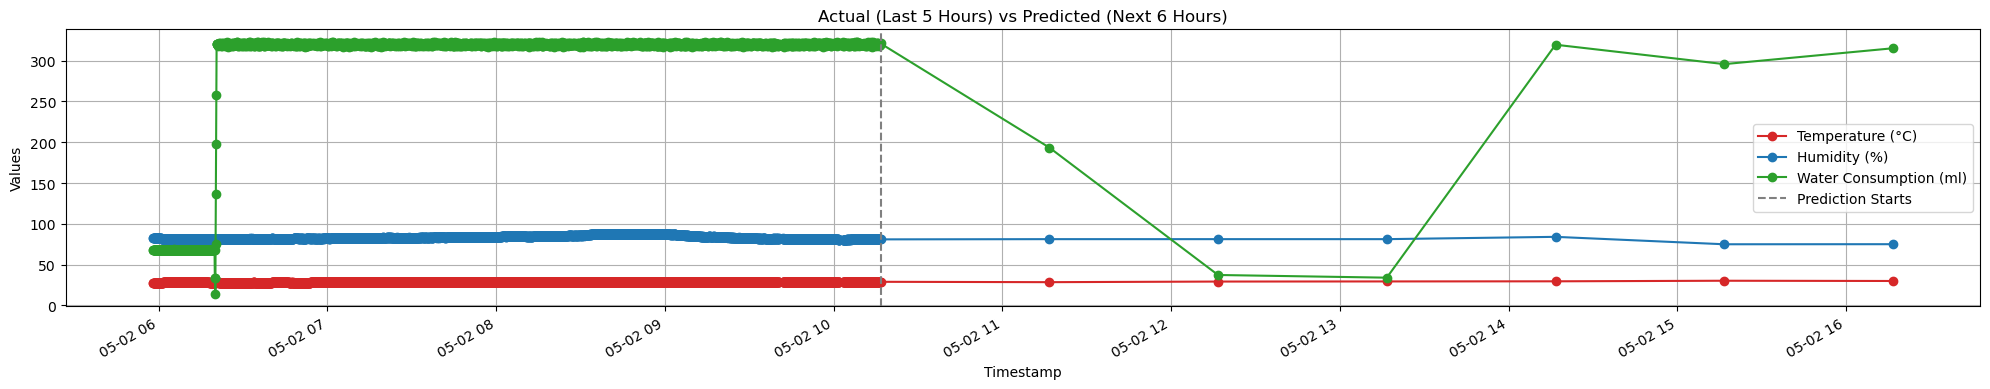

In [39]:
plt.figure(figsize=(20, 4))
x = combined_df_final['timestamp']

plt.plot(x, combined_df_final['predicted_temp'], label="Temperature (°C)", marker='o', color='tab:red')
plt.plot(x, combined_df_final['predicted_hum'], label="Humidity (%)", marker='o', color='tab:blue')
plt.plot(x, combined_df_final['predicted_water_weight'], label="Water Consumption (ml)", marker='o', color='tab:green')

plt.axvline(x=actual_df_5_real['timestamp'].iloc[-1], linestyle='--', color='gray', label="Prediction Starts")

plt.title("Actual (Last 5 Hours) vs Predicted (Next 6 Hours)")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
actual_df_5_real = last_5_df[['timestamp', 'temperature', 'humidity', 'food_weight']].copy()
actual_df_5_real = actual_df_5_real.rename(columns={
'temperature': 'predicted_temp',
'humidity': 'predicted_hum',
'food_weight': 'predicted_water_weight'
})
actual_df_5_real['label'] = 'Actual'

In [41]:
actual_df_5_real['timestamp'] = pd.to_datetime(actual_df_5_real['timestamp'])
actual_df_5_real['hour'] = actual_df_5_real['timestamp'].dt.floor('H')

hourly_avg = actual_df_5_real.groupby('hour').agg({
'predicted_temp': 'mean',
'predicted_hum': 'mean',
'predicted_water_weight': 'mean'
}).reset_index()

hourly_avg.columns = ['Hour', 'Avg_Temperature', 'Avg_Humidity', 'Avg_Water_Consumption']

C:\Users\Dinithi Thathsarani\AppData\Local\Temp\ipykernel_19900\1039714393.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  actual_df_5_real['hour'] = actual_df_5_real['timestamp'].dt.floor('H')


In [42]:
print("📊 Average Values per Hour (Last 5 Actual Hours):")
print(hourly_avg)

📊 Average Values per Hour (Last 5 Actual Hours):
                       Hour  Avg_Temperature  Avg_Humidity  \
0 2025-05-02 05:00:00+00:00        28.004545     83.000000   
1 2025-05-02 06:00:00+00:00        28.150853     81.863566   
2 2025-05-02 07:00:00+00:00        28.230793     83.421462   
3 2025-05-02 08:00:00+00:00        28.348678     86.077760   
4 2025-05-02 09:00:00+00:00        28.594913     83.330684   
5 2025-05-02 10:00:00+00:00        28.994048     81.011905   

   Avg_Water_Consumption  
0              67.966818  
1             234.035349  
2             320.019487  
3             320.013437  
4             320.020572  
5             320.127976  


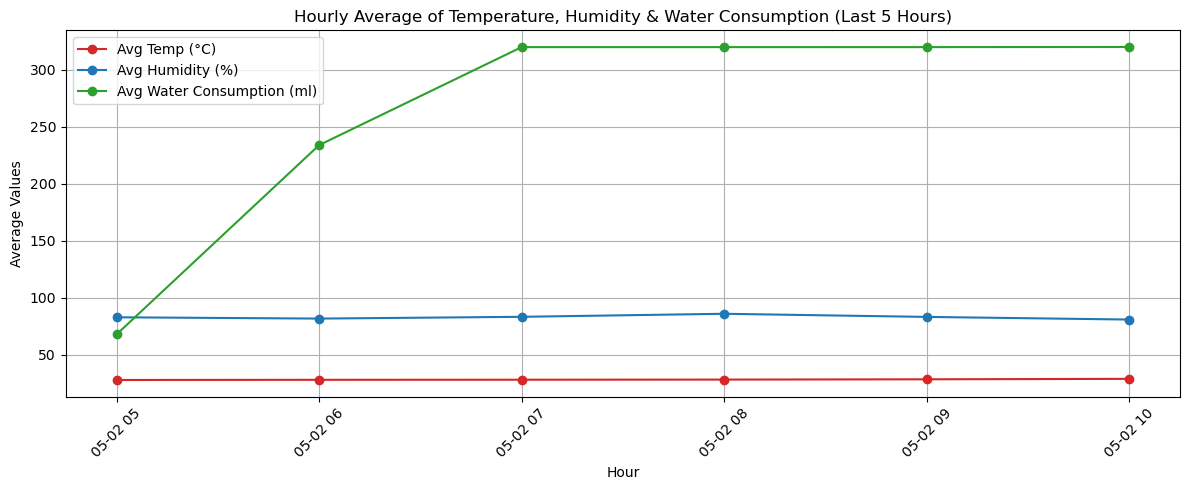

In [43]:
plt.figure(figsize=(12, 5))
plt.plot(hourly_avg['Hour'], hourly_avg['Avg_Temperature'], label='Avg Temp (°C)', marker='o', color='tab:red')
plt.plot(hourly_avg['Hour'], hourly_avg['Avg_Humidity'], label='Avg Humidity (%)', marker='o', color='tab:blue')
plt.plot(hourly_avg['Hour'], hourly_avg['Avg_Water_Consumption'], label='Avg Water Consumption (ml)', marker='o', color='tab:green')

plt.title("Hourly Average of Temperature, Humidity & Water Consumption (Last 5 Hours)")
plt.xlabel("Hour")
plt.ylabel("Average Values")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

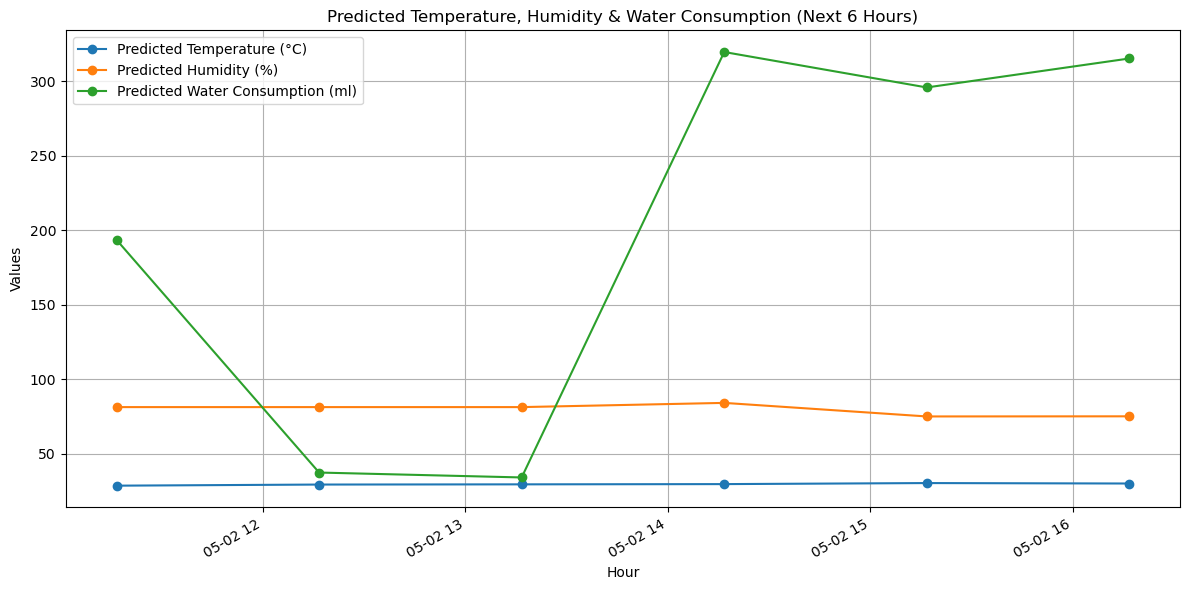

In [44]:
x = future_df['timestamp']

plt.figure(figsize=(12, 6))

plt.plot(x, future_df['predicted_temp'], label="Predicted Temperature (°C)", marker='o')
plt.plot(x, future_df['predicted_hum'], label="Predicted Humidity (%)", marker='o')
plt.plot(x, future_df['predicted_water_weight'], label="Predicted Water Consumption (ml)", marker='o')

plt.title("Predicted Temperature, Humidity & Water Consumption (Next 6 Hours)")
plt.xlabel("Hour")
plt.ylabel("Values")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Dinithi Thathsarani\AppData\Local\Temp\ipykernel_19900\1218832637.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(hourly_avg['Hour'], rotation=45)


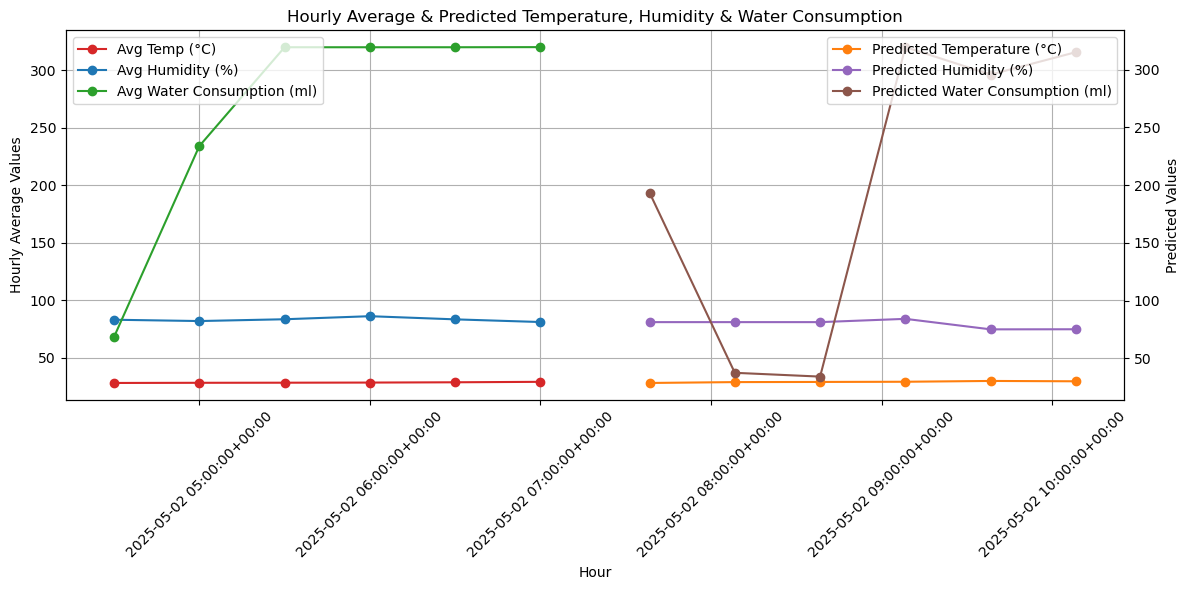

In [45]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot for hourly average (left y-axis)
ax1.plot(hourly_avg['Hour'], hourly_avg['Avg_Temperature'], label='Avg Temp (°C)', marker='o', color='tab:red')
ax1.plot(hourly_avg['Hour'], hourly_avg['Avg_Humidity'], label='Avg Humidity (%)', marker='o', color='tab:blue')
ax1.plot(hourly_avg['Hour'], hourly_avg['Avg_Water_Consumption'], label='Avg Water Consumption (ml)', marker='o', color='tab:green')

# Labels and title for the first y-axis
ax1.set_xlabel("Hour")
ax1.set_ylabel("Hourly Average Values")
ax1.set_title("Hourly Average & Predicted Temperature, Humidity & Water Consumption")
ax1.set_xticklabels(hourly_avg['Hour'], rotation=45)
ax1.grid(True)

# Create a second y-axis for predicted values
ax2 = ax1.twinx()

# Plot for predicted values (right y-axis)
ax2.plot(x, future_df['predicted_temp'], label="Predicted Temperature (°C)", marker='o', color='tab:orange')
ax2.plot(x, future_df['predicted_hum'], label="Predicted Humidity (%)", marker='o', color='tab:purple')
ax2.plot(x, future_df['predicted_water_weight'], label="Predicted Water Consumption (ml)", marker='o', color='tab:brown')

# Labels for the second y-axis
ax2.set_ylabel("Predicted Values")

# Legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()
